# Project 6: Time Series Analysis & Forecasting 📈

**Project Objective:** To build a time series model to forecast the number of airline passengers for future months. This project provides a comprehensive, step-by-step guide to time series analysis, from data decomposition and stationarity testing to building and evaluating ARIMA and SARIMA models.

**Class Duration:** 2.5 hours

### Core Concepts We'll Cover:
1.  **Time Series Fundamentals:** Understanding the components of a time series (Trend, Seasonality, Residuals).
2.  **Stationarity:** Learning what stationarity is, why it's crucial for many models, and how to test for it (Augmented Dickey-Fuller test).
3.  **Data Transformation:** Applying techniques like differencing and log transforms to make a series stationary.
4.  **Model Identification:** Using Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots to determine model parameters.
5.  **ARIMA Modeling:** Building a baseline ARIMA model for forecasting.
6.  **SARIMA Modeling:** Extending ARIMA to build a powerful SARIMA model that explicitly handles seasonality.
7.  **Forecasting & Evaluation:** Making predictions and evaluating model performance.

### **Theoretical Concept: What is a Time Series?**

A time series is a sequence of data points collected or recorded at specific time intervals (e.g., daily, monthly, yearly). Unlike other datasets we've worked with, the order of data points in a time series is critical.

A time series can be broken down into several components:
1.  **Trend:** The long-term upward or downward movement in the data.
2.  **Seasonality:** A repeating, predictable pattern over a fixed period (e.g., sales are higher every December).
3.  **Cyclical Component:** Patterns that occur at irregular, non-fixed intervals (e.g., business cycles). This is often harder to model and is sometimes combined with the trend.
4.  **Residuals (or Noise):** The random, irregular fluctuations that are left over after the other components have been removed.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
data = pd.read_csv('airline_passenger_timeseries.csv')
data

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


## Step 2: Exploratory Data Analysis & Decomposition 


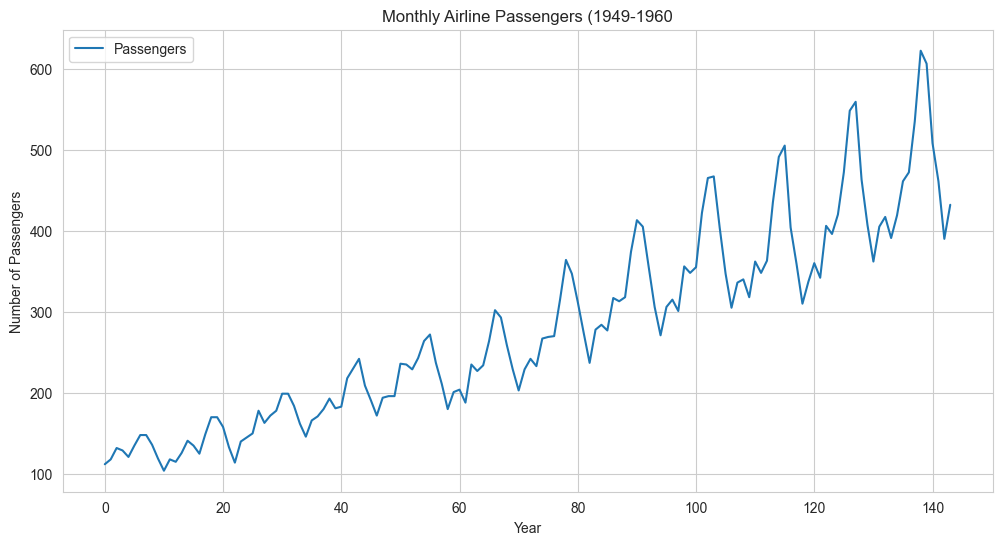

In [3]:
data.plot()
plt.title('Monthly Airline Passengers (1949-1960')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

**Initial Observation:** The plot clearly shows two strong patterns:
1.  **Upward Trend:** The number of passengers is increasing over time.
2.  **Seasonality:** There is a clear, repeating annual pattern (peaks and troughs within each year).
3.  **Increasing Variance:** The seasonal fluctuations appear to be getting larger over time.

sm.tsa.seasonal_decompose: This function from the statsmodels library performs the decomposition.

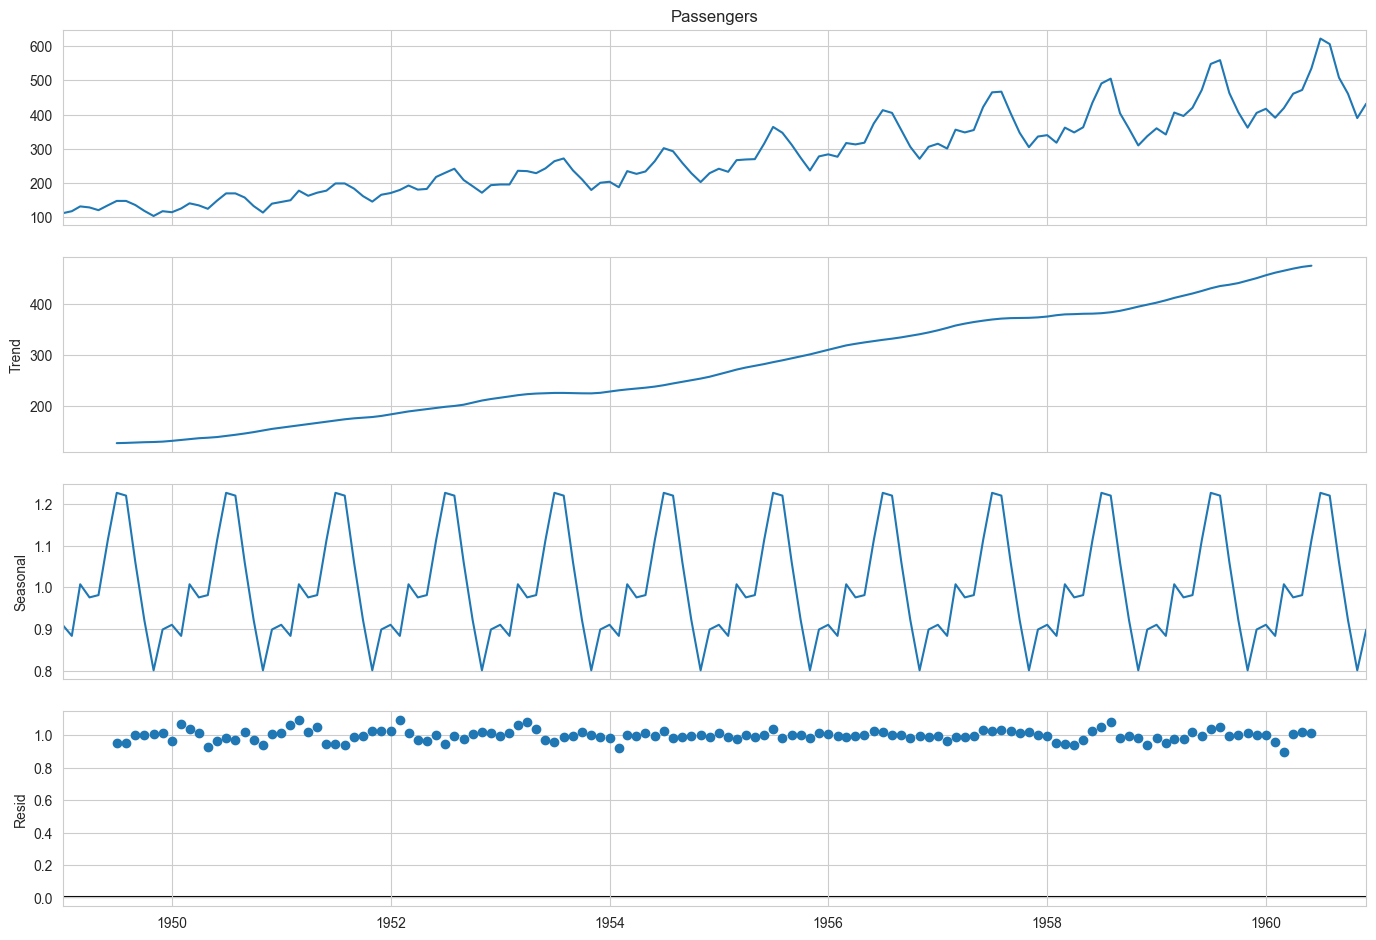

In [4]:
# Convert 'Month' to datetime and set as index
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(data['Passengers'], model='multiplicative')
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

### Step 3: Stationarity Testing 
Before we can build a model like ARIMA, the time series needs to be **Stationary**

#### **Theoretical Concept: Stationarity**
A time series is said to be stationary if its statistical properties—specifically the **mean**, **variance**, and **autocorrelation**—are all constant over time.

- **Why is it important?** Stationary series are easier to model and forecast. If a series is stationary, its past behavior is a good predictor of its future behavior. Our passenger data is clearly **non-stationary** because its mean (the trend is increasing) and variance (the seasonal swings are growing) are not constant.

**How to test for it?**
1.  **Visual Inspection:** Look at the plot. Is there a clear trend or seasonality?
2.  **Statistical Tests:** The **Augmented Dickey-Fuller (ADF) Test** is a common statistical test.
    - **Null Hypothesis ($H_0$):** The series is non-stationary.
    - **Alternative Hypothesis ($H_1$):** The series is stationary.

We want to **reject the null hypothesis**. To do this, we need the **p-value** from the test to be less than a significance level (e.g., 0.05).

#### Think of the ADF test as asking the question: "Does this time series have a trend or other patterns that make it non-stationary?"

Here's what each part means:

* Test Statistic: This is a number calculated from your data. It's the main result of the test.
* p-value: This is the most important number for a beginner. It tells you how likely it is that you would get your results if the time series were actually stationary (which is the opposite of what we usually want).
* If the p-value is small (usually less than 0.05): This means it's very unlikely to get these results if the series were stationary. So, you can confidently say, "Okay, this series is not stationary."
* If the p-value is large (like yours, 0.99): This means it's quite likely to get these results even if the series were stationary. So, you cannot confidently say it's not stationary. In other words, you fail to reject the null hypothesis, which is that the series is non-stationary.
###Lags Used: This is the number of past data points the test looked at to help make its decision.
* Number of Observations Used: This is how many data points from your time series were actually used in the test calculation.
* Critical Value (1%), (5%), (10%): These are threshold values. If your "Test Statistic" is smaller than one of these critical values (more negative), you would reject the null hypothesis at that confidence level. For example, if your Test Statistic was less than -3.48 (the 1% critical value), you'd be very confident (99%) that the series is stationary.
Why do we use it?

* We use the ADF test (and look at the p-value) because many powerful time series forecasting models, like ARIMA, assume that the data they are working with is stationary. If your data is not stationary, these models might not work well or give you inaccurate forecasts. The ADF test gives us a statistical way to check this assumption before we build our models.

* In your case, the high p-value (0.99) tells us that your 'Passengers' data is non-stationary, just as we suspected from looking at the plot earlier. This confirms that you need to perform transformations (like differencing) to make it stationary before building an ARIMA model.

In [5]:
def test_stationarity(timeseries):
    # Perform Dicky-Fuiler test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(data['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


dftest = adfuller(timeseries, autolag='AIC'): This is the core of the test. It runs the Augmented Dickey-Fuller (ADF) test on your timeseries data. The autolag='AIC' part helps the test figure out the best settings to use. The results of the test are stored in the variable dftest.

**Result:** The p-value is `0.99`, which is much greater than 0.05. Therefore, we **fail to reject the null hypothesis**. Our data is officially non-stationary, and we need to transform it.

### Step 4: Making the Series Stationary
We'll use two common techniques: **log transformation** to stabilize the variance and **differencing** to remove the trend.

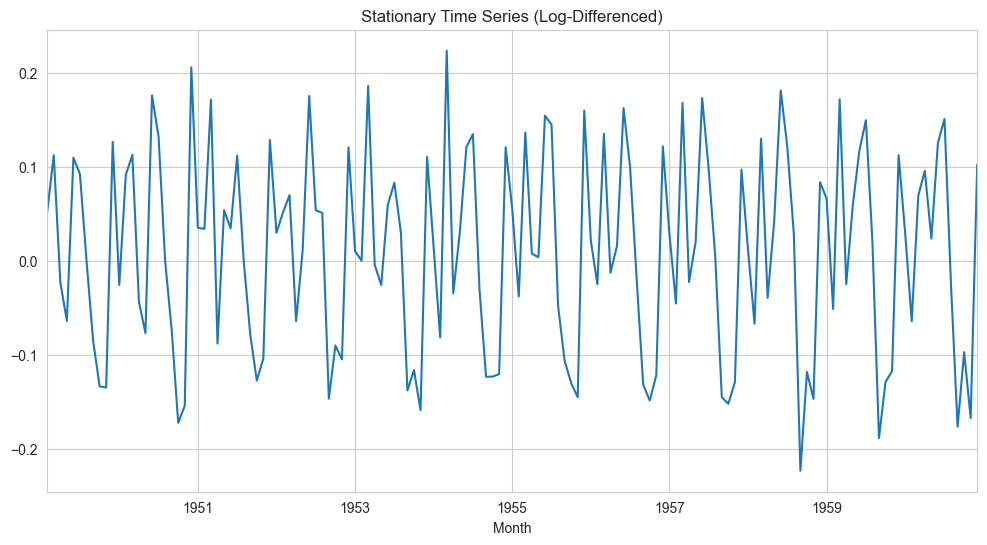

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [6]:
# 1. Apply log transformation to stabilize the variance 
data_log = np.log(data['Passengers'])

# 2. Apply differencing to remove the trend 
data_diff = data_log.diff().dropna()

# Plot the stationary series 
data_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

# Retest for Stationarity 
test_stationarity(data_diff)

**Result:** The new p-value is `0.02`, which is less than 0.05. We can now **reject the null hypothesis**. Our series is stationary and ready for modeling!

ACF (Autocorrelation Function): Measures the correlation between a time series and its lagged versions (e.g., how much the value today is correlated with the value yesterday, the day before, etc.). The plot shows spikes at lags where there is significant autocorrelation.
PACF (Partial Autocorrelation Function): Measures the direct correlation between a time series and its lagged versions, after removing the effects of the intermediate lags. It helps identify the direct relationship between the current value and a specific lagged value.
These plots help us determine the p and q parameters for the ARIMA model:

p (AR term): Suggested by the number of significant lags in the PACF plot where the spikes "cut off" or drop to near zero.
q (MA term): Suggested by the number of significant lags in the ACF plot where the spikes "cut off".

### Step 5: Model Identification with ACF and PACF Plots

#### **Theoretical Concept: ACF and PACF**
To choose the parameters for our ARIMA model, we use autocorrelation plots.

- **Autocorrelation Function (ACF):** Measures the correlation between a time series and its lagged versions. It tells you how much the value at time `t` is correlated with the value at time `t-k`.
- **Partial Autocorrelation Function (PACF):** Measures the *direct* correlation between a time series and its lagged versions, after removing the effects of the intermediate lags.

**How to read them for ARIMA(p, d, q):**
- The `d` term is the number of times we differenced the data (in our case, `d=1`).
- The `p` (AR term) is suggested by the number of significant lags in the **PACF** plot.
- The `q` (MA term) is suggested by the number of significant lags in the **ACF** plot.

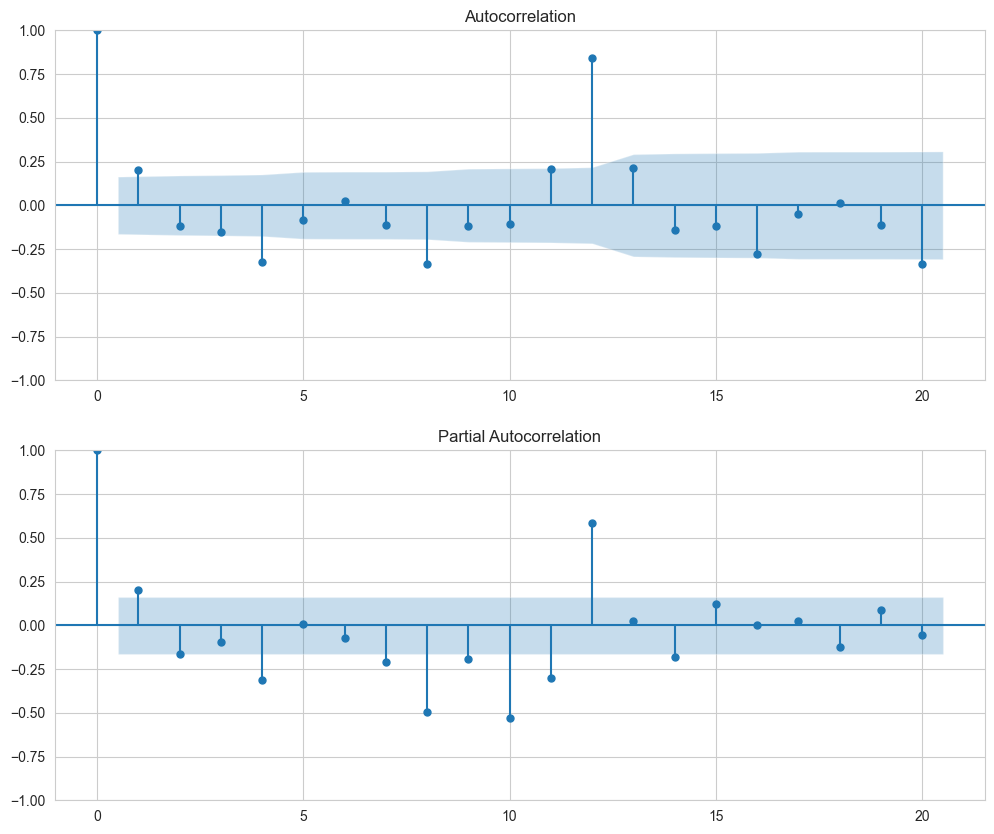

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(data_diff, ax=ax1, lags=20)
plot_pacf(data_diff, ax=ax2, lags=20)
plt.show()

**Interpretation:**
- **PACF Plot:** Cuts off sharply after lag 1. This suggests `p=1`.
- **ACF Plot:** Also seems to cut off after lag 1. This suggests `q=1`.
Based on this, a good starting point for our model is **ARIMA(1, 1, 1)**.

## **Theoretical Concept: ARIMA**
**AutoRegressive Integrated Moving Average (ARIMA)** models are a class of statistical models for analyzing and forecasting time series data. An ARIMA model is characterized by three parameters:

- **AR (Autoregressive) - p:** The number of lag observations included in the model. This term captures the relationship between the current observation and its past values.
- **I (Integrated) - d:** The number of times that the raw observations are differenced. This is done to make the time series stationary.
- **MA (Moving Average) - q:** The size of the moving average window. This term captures the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The model is typically denoted as **ARIMA(p, d, q)**.

### Step 6: Building the ARIMA Model

C:\Users\kirsh\Desktop\ML\alllib\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


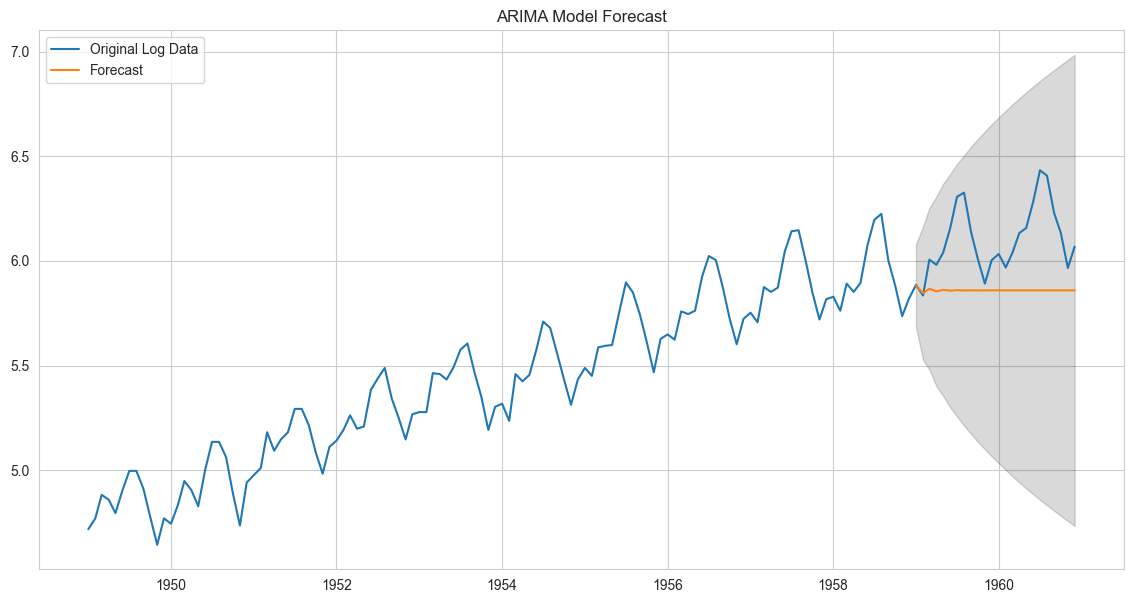

In [8]:
# Split data into training and test sets
train_data = data_log[:'1958']
test_data = data_log['1959':]

# Build ARIMA model
model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(data_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

**ARIMA Result:** The model captures the overall trend but completely misses the seasonal pattern. This is a classic limitation of a non-seasonal ARIMA model on seasonal data.

## Step 7: Building a SARIMA Model for Seasonality

#### **Theoretical Concept: SARIMA**
**Seasonal AutoRegressive Integrated Moving Average (SARIMA)** is an extension of ARIMA that explicitly models the seasonal component.

It is written as **SARIMA(p, d, q)(P, D, Q, m)**, where:
- `(p, d, q)` are the non-seasonal parameters:
    - **p (non-seasonal AR order):** The number of non-seasonal lagged observations included in the model.
    - **d (non-seasonal differencing order):** The number of times the data is differenced to remove non-seasonal trend.
    - **q (non-seasonal MA order):** The number of non-seasonal lagged forecast errors included in the model.

- `(P, D, Q, m)` are the seasonal parameters:
    - **P (seasonal AR order):** The number of seasonal lagged observations included in the model.
    - **D (seasonal differencing order):** The number of times the data is differenced seasonally to remove seasonal trend.
    - **Q (seasonal MA order):** The number of seasonal lagged forecast errors included in the model.
    - **m (number of periods in a season):** The number of time steps for a single seasonal period (e.g., `m=12` for monthly data with an annual seasonality, `m=4` for quarterly data).

C:\Users\kirsh\Desktop\ML\alllib\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


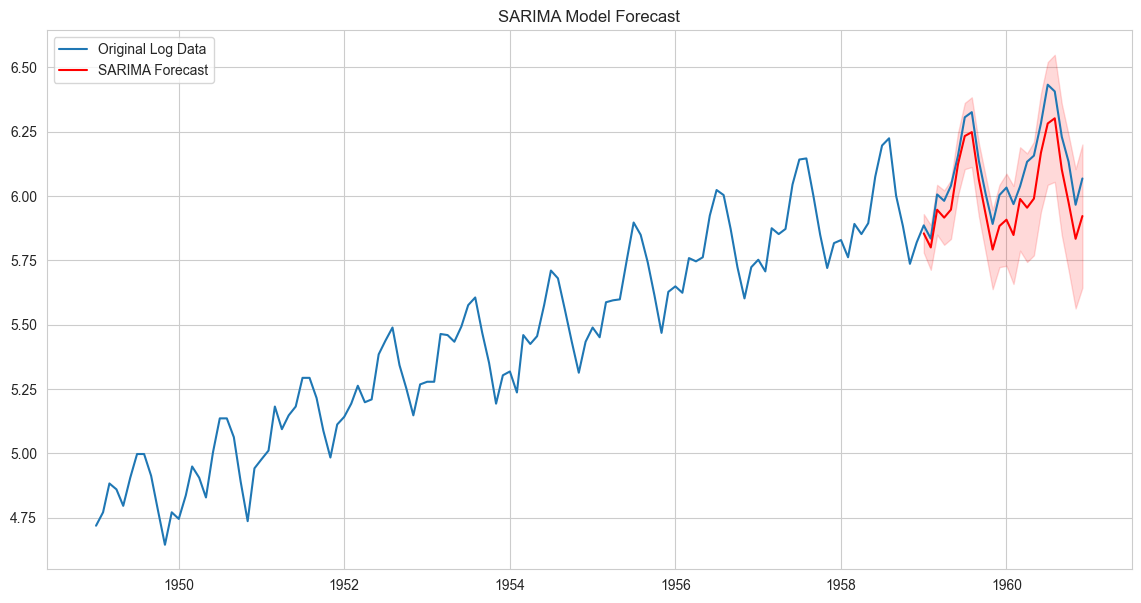

In [9]:
# Build SARIMA model
# We can find the optimal P, D, Q through a grid search, but common values are 1.
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(data_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

**SARIMA Result:** This is a massive improvement! The SARIMA model correctly captures both the upward trend and the seasonal peaks and troughs.

## Step 8: Final Evalutaion

SARIMA Model RMSE: 48.26


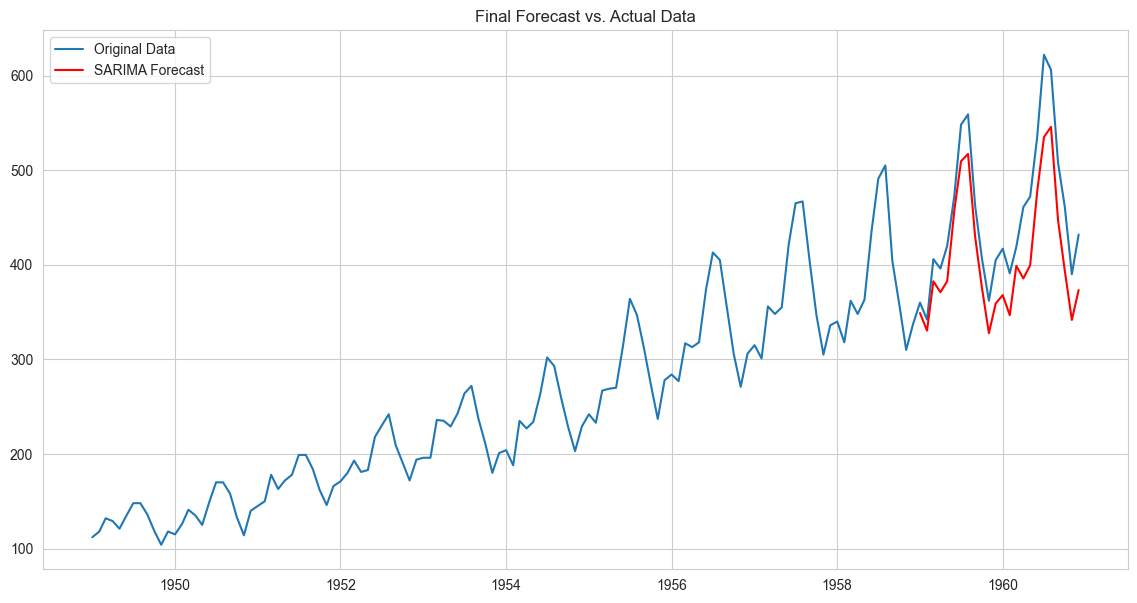

In [10]:
# Reverse the log transformation to get actual passenger numbers
original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))
print(f"SARIMA Model RMSE: {rmse:.2f}")

# Plot final results
plt.figure(figsize=(14, 7))
plt.plot(data['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()

### Step 9: Conclusion

In this project, we built a complete time series forecasting pipeline.

**Key Steps Undertaken:**
1.  **Decomposed the time series** to identify its underlying trend and strong yearly seasonality.
2.  **Confirmed non-stationarity** using the Augmented Dickey-Fuller test.
3.  **Transformed the data** using log transforms and differencing to achieve stationarity, a prerequisite for ARIMA modeling.
4.  **Used ACF/PACF plots** to identify the initial parameters for our model.
5.  **Built a baseline ARIMA model** which captured the trend but failed to model the seasonality.
6.  **Built an advanced SARIMA model** that successfully captured both trend and seasonality, resulting in a much more accurate forecast.
7.  **Evaluated the final model** on the original scale using RMSE.

This project clearly demonstrates the importance of identifying and specifically modeling seasonality for accurate time series forecasting.

### Text Submission Criteria

Please submit your analysis based on the following criteria:

1. **Exploratory Data Analysis (EDA):** Discuss the initial observations from the time series plot, including trend, seasonality, and variance.
2. **Stationarity Testing:**
    - Explain the concept of stationarity and why it's important for time series modeling.
    - Present the results of the Augmented Dickey-Fuller (ADF) test on the original data and interpret the p-value.
    - Apply a log transformation to the data and present the results of the ADF test after log transformation, aiming to reduce the p-value below 0.05. Discuss your findings.
    - Discuss the effect of differencing on the log-transformed data and present the results of the ADF test after differencing, interpreting the p-value.
3. **ARIMA Model Performance:** Based on the stationarity test results after log transformation (before differencing), discuss whether you would expect a non-seasonal ARIMA model to perform well on the log-transformed data. Build and evaluate a non-seasonal ARIMA model on the log-transformed data (without differencing) and compare its performance to the SARIMA model built later in the notebook.}

#### What is a Time Series?
A time series is a sequence of data points collected or recorded at successive time intervals, where the order of observations is integral to the analysis. In the airline passengers dataset, the number of passengers is tracked monthly from 1949 to 1960.

#### What are the Components of a Time Series?
 - **Trend:** The long-term increase or decrease in the data over time, such as the general upward slope in the passenger numbers.
 - **Seasonality:** Predictable, repeating fluctuations tied to time of year or month, like higher air travel in certain months.
 - **Cyclicality:** Patterns recurring over non-fixed periods, often linked to economic cycles; less distinct in this dataset.
 - **Residuals/Noise:** Irregular or unpredictable variations left after accounting for trend and seasonality.

#### Why is Stationarity Important, and How is it Tested?
Stationarity means the statistical properties of a series (mean, variance) do not change over time, which is critical for accurate modeling with ARIMA and related models:
- Many time series methods assume constant mean and variance for reliable forecasting.
- **Testing:** The Augmented Dickey-Fuller (ADF) test is commonly used. If the p-value is below a certain threshold (often 0.05), the series is considered stationary.

#### How Can a Time Series Be Made Stationary?
- **Differencing:** Subtracting the preceding value from the current one to remove trends or seasonality.
- **Log Transformation:** Applying a log transform to stabilize the variance.
- **Detrending/Removing Seasonality:** Methods like subtracting a moving average or decomposing the series into components.


#### What Are ACF and PACF Used For?
- **ACF (Autocorrelation Function):** Shows correlation of current value with its previous values; helps determine the order of MA (moving average) models.
- **PACF (Partial Autocorrelation Function):** Shows correlation of current value with previous values, controlling for other lags; helps determine the order of AR (autoregressive) models.

#### What Is ARIMA? What About SARIMA?
- **ARIMA (AutoRegressive Integrated Moving Average):** A modeling technique combining auto-regression (AR), differencing (I), and moving average (MA) to model time series. It suits non-seasonal data or data made stationary.
  **SARIMA (Seasonal ARIMA):** Extends ARIMA by explicitly modeling seasonal components with extra parameters (seasonal order and period).
- SARIMA is better for data with strong periodicity, like monthly airline passengers.

#### How Are ARIMA/SARIMA Models Evaluated?
Models are usually evaluated by:
- Visual Inspection: Comparing predicted vs. actuals in a plot.
- Metrics: Calculating error measures like Mean Squared Error (MSE) or Root Mean Squared Error (RMSE) on test set.